# Week 10

We use named entity recognition (NER) task as a case for study the NLP applications in in Healthcare.
Other tasks has a similar steps as the NER.

The named entity recognition (NER) is a form of NLP. It involves the identification of key information in the text and classification into a set of predefined categories. An entity is basically the thing that is consistently talked about or refer to in the text.

In short words, given an input text, label the specified entity by a model.

In [ ]:
!pip install transformers==4.20.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Oct 12 04:49:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install -U -q PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
if not os.path.exists('/content/train.txt'):
    link = '1Io-TQeWd8ZhX8YWQwUjl8AEkZb-URTXR'  # Restricted shared link
    downloaded = drive.CreateFile({'id':link})
    downloaded.GetContentFile('train.txt')


if not os.path.exists('/content/validation.txt'):
    link = '1gc1sPd-9dYi4Cl1o4KF3ZpJG-WCO4gA5'  # Restricted shared link
    downloaded = drive.CreateFile({'id':link})
    downloaded.GetContentFile('validation.txt')


if not os.path.exists('/content/test.txt'):
    link = '11PP3Ofwee_JL1tBr5_3XGE7Vqcc8vgMh'  # Restricted shared link
    downloaded = drive.CreateFile({'id':link})
    downloaded.GetContentFile('test.txt')


## 1. Pre-Processing

In [ ]:
import pandas as pd
import numpy as np
import torch

train = pd.read_table('./train.txt', delimiter = ' ', header=None, names=['word', 'tag1', 'tag2', 'tag3'])
valid = pd.read_table('./validation.txt', delimiter = ' ', header=None, names=['word', 'tag1', 'tag2', 'tag3'])
test = pd.read_table('./test.txt', delimiter = ' ', header=None, names=['word', 'tag1', 'tag2', 'tag3'])

print(len(train), len(valid), len(test))

102505 9143 19684


In [ ]:
train.head(10)

,word,tag1,tag2,tag3
0,-DOCSTART-,JJ,B-NP,O
1,-EMPTYLINE-,NNP,I-NP,O
2,Admission,NNP,I-NP,O
3,Date,NNP,I-NP,O
4,:,:,O,O
5,2013-10-29,JJ,B-NP,O
6,Discharge,NN,I-NP,O
7,Date,NNP,I-NP,O
8,:,:,O,O
9,2013-11-04,JJ,B-NP,O


In [ ]:
sentence = train['word'].to_list()
sentence[:10]

['-DOCSTART-',
 '-EMPTYLINE-',
 'Admission',
 'Date',
 ':',
 '2013-10-29',
 'Discharge',
 'Date',
 ':',
 '2013-11-04']

In [ ]:
# labels
labels = [i.split() for i in train['tag3'].values]

# Check how many labels are there in the dataset
unique_labels = set()

for lb in labels:
      [unique_labels.add(i) for i in lb if i not in unique_labels]

print(unique_labels)

{'B-treatment', 'B-person', 'B-problem', 'I-problem', 'I-treatment', 'B-pronoun', 'I-person', 'I-test', 'B-test', 'O'}


In [ ]:
# Map each label into its id representation and vice versa
labels_to_ids = {k: v for v, k in enumerate(sorted(unique_labels))}
ids_to_labels = {v: k for v, k in enumerate(sorted(unique_labels))}
print(labels_to_ids)

{'B-person': 0, 'B-problem': 1, 'B-pronoun': 2, 'B-test': 3, 'B-treatment': 4, 'I-person': 5, 'I-problem': 6, 'I-test': 7, 'I-treatment': 8, 'O': 9}


## 2. NER detector by pre-trained BERT model

In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline

tokenizer = AutoTokenizer.from_pretrained("dslim/bert-base-NER")
model = AutoModelForTokenClassification.from_pretrained("dslim/bert-base-NER")

nlp = pipeline("ner", model=model, tokenizer=tokenizer)
inputs = ' '.join(str(item) for item in sentence[:600])

ner_results = nlp(inputs)
print(ner_results)

Downloading:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/829 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/413M [00:00<?, ?B/s]

[{'entity': 'B-MISC', 'score': 0.27828318, 'index': 9, 'word': 'E', 'start': 12, 'end': 13}, {'entity': 'B-MISC', 'score': 0.7487909, 'index': 49, 'word': 'CA', 'start': 124, 'end': 126}, {'entity': 'B-PER', 'score': 0.99757737, 'index': 75, 'word': 'Angie', 'start': 218, 'end': 223}, {'entity': 'I-PER', 'score': 0.9840194, 'index': 76, 'word': 'C', 'start': 224, 'end': 225}, {'entity': 'I-PER', 'score': 0.92885363, 'index': 77, 'word': '##M', 'start': 225, 'end': 226}, {'entity': 'I-PER', 'score': 0.99779224, 'index': 78, 'word': 'Johnson', 'start': 227, 'end': 234}, {'entity': 'B-PER', 'score': 0.90228057, 'index': 122, 'word': 'Andersen', 'start': 397, 'end': 405}, {'entity': 'B-ORG', 'score': 0.77620894, 'index': 228, 'word': 'At', 'start': 835, 'end': 837}, {'entity': 'B-LOC', 'score': 0.45045993, 'index': 229, 'word': '##tle', 'start': 837, 'end': 840}, {'entity': 'I-ORG', 'score': 0.81037825, 'index': 230, 'word': '##boro', 'start': 840, 'end': 844}, {'entity': 'I-ORG', 'score':

## 3. Visualization

In [ ]:
from pprint import pprint
import spacy
from spacy import displacy

nlp = spacy.load('en_core_web_sm')

# sentence = '''Prime Minister Jacinda Ardern has claimed that New Zealand had won a big
# battle over the spread of coronavirus. Her words came as the country begins to exit from its lockdown.'''
# sentence = "Pt took aspirin 325 mg for knee pain."
inputs = ' '.join(str(item) for item in sentence[:600])


entities= nlp(inputs)

for ent in entities.ents:
    print(ent.text,ent.label_)
    # break

# visualize named entities
displacy.render(entities, style='ent', jupyter=True)

2013-10-29 CARDINAL
2013-11-04 CARDINAL
1943-01-06 DATE
No Known Allergies to Drugs Attending ORG
CM Johnson PERSON
Major Surgical or Invasive Procedure ORG
5 CARDINAL
Andersen PERSON
71-year-old DATE
three CARDINAL
48 CARDINAL
the age of 10 DATE
23 years ago DATE
12 years ago DATE
Attleboro Donald Family PERSON
91 years old DATE
Physical Exam : Awake ORG
CV GPE
RRR NORP
NT GPE
NABS Ext ORG
1 CARDINAL
Results PERSON
2013-10 CARDINAL
11.4 CARDINAL
# CARDINAL
RBC ORG
3.09 CARDINAL
# CARDINAL
Hgb NORP
9.1 CARDINAL
# CARDINAL
Hct - 27.5 GPE
# CARDINAL
MCH GPE
29.5 CARDINAL
MCHC ORG
33.3 CARDINAL
RDW ORG
Plt Ct PERSON
180 CARDINAL
16.2 CARDINAL
29.0 CARDINAL
INR(PT ORG
Plt Ct PERSON
180 CARDINAL
01:09 PM TIME
Glucose - 172 CARDINAL
142 CARDINAL
111 CARDINAL
01:09 PM TIME
BLOOD Mg - 2.6 PERSON
2013-10-29 DATE
CABG NORP
ICU ORG
first ORDINAL
6 MONEY
Diovan 160 LAW
Metformin PERSON
500 CARDINAL
two CARDINAL
Omeprazole PRODUCT
20 mg q PM Discharge Medications TIME
1 CARDINAL
100 CARDINAL
One CA

## 4. How to Build your own personal NER detector ?
- How to fine-tuning encoder-decoder (in this case: BERT-Classsifer) for the downstream task by using existing model followed by your own classsifer

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertForTokenClassification, AdamW, BertTokenizer, BertConfig

max_len = 16
batch_size = 256

In [ ]:
def load_ner_data(data_path: str) -> pd.DataFrame:
    df = pd.read_table(data_path, delimiter = ' ', header=None, names=['word', 'tag1', 'tag2', 'tag3'])
    seq = 0
    id = 0
    sent_id = torch.zeros(len(df)).int()
    while(seq+max_len-2 < len(sent_id)-1):
        sent_id[seq: seq + max_len - 2] = id
        seq = seq + max_len - 2
        id = id + 1
    sent_id[seq:] = id
    # df.assign(sid=sent_id)
    # df = df.insert(loc=4, column='sid', value=sent_id)
    return df.assign(sid=sent_id)

In [ ]:
train = load_ner_data("./train.txt")
train.tail(10)

,word,tag1,tag2,tag3,sid
102495,before,IN,B-VP,O,7321
102496,meals,NNS,B-NP,O,7321
102497,.,.,B-VP,O,7321
102498,9.,CD,O,O,7321
102499,Fluconazole,JJ,O,B-treatment,7321
102500,200,CD,O,O,7321
102501,mg,NN,B-NP,O,7321
102502,p.o.,NN,I-NP,O,7321
102503,q.h.d.,JJ,B-NP,O,7321
102504,Patient,NNP,I-NP,B-person,7321


In [ ]:
train.describe(include=object)

,word,tag1,tag2,tag3
count,102493,102505,102505,102505
unique,11722,43,4,10
top,.,NN,O,O
freq,5297,17734,37292,71047


In [ ]:
def preprocess(df):
    map_func = lambda s: [(w, l) for w, l in zip(s["word"].values.tolist(), s["tag3"].values.tolist())]
    grouped = df.groupby("sid").apply(map_func)
    text = [t for t in grouped]
    sentences = [[word[0] for word in sentence] for sentence in text]
    labels = [[word[1] for word in sentence] for sentence in text]

    label_values = list(set(df['tag3'].values))
    label_values.append("PAD")
    label2idx = {t: i for i, t in enumerate(label_values)}

    for i in range(len(labels)):
        labels[i].insert(0, "PAD")
        labels[i].append("PAD")
    labels[-1] = labels[-1] + ["PAD"] * (max_len - len(labels[-1]))
    # print(labels[0])

    targets = [[label2idx[l] for l in label] for label in labels]

    return sentences, targets, label2idx

In [ ]:
def tokenize_with_pad(sentences, targets):

    tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

    batchs = {"input_ids": [], "attention_mask": [], "labels": []}
    # print("len(sentences[-1]), len(targets[-1])", len(sentences[-1]), len(targets[-1]))

    for sentence, target in zip(sentences, targets):

        encoding = tokenizer.encode_plus(
        sentence,
        add_special_tokens=True,
        max_length=max_len, # 510 + [CLS] + [PAD]
        return_token_type_ids=False,
        padding="max_length",
        truncation=False,
        return_attention_mask=True,
        return_tensors='pt',
        )
    #     encoding['labels'] = encoding.input_ids.detach().clone()
    #     batchs.append(encoding)

        batchs["input_ids"].append(encoding["input_ids"].squeeze())
        batchs["attention_mask"].append(encoding["attention_mask"].squeeze())
        batchs["labels"].append(torch.LongTensor(target))

    # inputs["input_ids"] = torch.cat(batchs["input_ids"], dim=0)
    # print(len(batchs["input_ids"]))
    # print(batchs["input_ids"][-1])
    batchs["input_ids"] = torch.stack(batchs["input_ids"])
    batchs["attention_mask"] = torch.stack(batchs["attention_mask"])
    batchs["labels"] = torch.stack(batchs["labels"])

    return batchs

In [ ]:
sentences, targets, label2idx = preprocess(train)
batchs = tokenize_with_pad(sentences, targets)

print(batchs["input_ids"].shape, batchs["attention_mask"].shape, batchs["labels"].shape)
print(batchs["input_ids"][-1])
print(batchs["attention_mask"][-1])
print(batchs["labels"][-1])

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

torch.Size([7322, 16]) torch.Size([7322, 16]) torch.Size([7322, 16])
tensor([  101,  1904,  1196, 13077,   119,   100,   100,  2363, 17713,   100,
          100,   100,   102,     0,     0,     0])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0])
tensor([10,  9,  9,  9,  9,  9,  0,  9,  9,  9,  9,  1, 10, 10, 10, 10])


In [ ]:
class NERDataset(torch.utils.data.Dataset):
    def __init__(self, batchs):
        self.batchs = batchs

    def __getitem__(self, idx):
        return {key: val[idx] for key, val in self.batchs.items()}

    def __len__(self):
        return len(self.batchs["input_ids"])

  train = NERDataset()

  train[1]
  len(train)


In [ ]:
def build_loaders(batchs, data_type='train', batch_size=batch_size, num_workers=4):
    # transforms = get_transforms(mode=mode)
    dataset = NERDataset(batchs)
    # if data_type == 'train':
    #     sampler = RandomSampler(dataset)
    #     dataloader = DataLoader(dataset, sampler=sampler, batch_size=batch_size, num_workers=num_workers)
    # else:
    #     dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

In [ ]:
train_loader = build_loaders(batchs, data_type='train')

batch = next(iter(train_loader))
print(batch['input_ids'].shape, batch['attention_mask'].shape, batch["labels"].shape)

torch.Size([256, 16]) torch.Size([256, 16]) torch.Size([256, 16])


### Build Model

In [ ]:
model = BertForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=len(label2idx),
    output_attentions = False,
    output_hidden_states = False
)

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

### Train Model

In [ ]:
from tqdm import tqdm  # for our progress bar


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# and move our model over to the selected device
model.to(device)
# activate training mode
model.train()

optim = AdamW(model.parameters(), lr=1e-3, no_deprecation_warning=True)

epochs = 10

loop = tqdm(range(epochs), leave=True)

record = []

for epoch in loop:
    b_loss = 0.
    # setup loop with TQDM and dataloader
    # loop = tqdm(train_loader, leave=True)
    for batch in train_loader:
        # initialize calculated gradients (from prev step)
        optim.zero_grad()
        # pull all tensor batches required for training
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        # print(labels)
        # process
        outputs = model(input_ids, token_type_ids=None,
                        attention_mask=attention_mask, labels=labels)
        # get the loss
        # extract loss
        loss = outputs.loss
        # calculate loss for every parameter that needs grad update
        loss.backward()
        # update parameters
        optim.step()
        # print relevant info to progress bar
        b_loss += loss.data.item()
    b_loss = b_loss / len(train_loader)
    record.append(b_loss)
    loop.set_description(f'Epoch {epoch}')
    loop.set_postfix(loss=b_loss)
    print(" loss: ", b_loss)

Epoch 0:  10%|█         | 1/10 [00:20<03:02, 20.27s/it, loss=1.95]

 loss:  1.9478099962760662


Epoch 1:  20%|██        | 2/10 [00:37<02:29, 18.68s/it, loss=1.49]

 loss:  1.490109451885881


Epoch 2:  30%|███       | 3/10 [00:55<02:09, 18.43s/it, loss=1.49]

 loss:  1.4883786357682327


Epoch 3:  40%|████      | 4/10 [01:14<01:51, 18.52s/it, loss=1.49]

 loss:  1.4876638404254257


Epoch 4:  50%|█████     | 5/10 [01:33<01:33, 18.80s/it, loss=1.49]

 loss:  1.487574528003561


Epoch 5:  60%|██████    | 6/10 [01:53<01:16, 19.16s/it, loss=1.49]

 loss:  1.4888293126533771


Epoch 6:  70%|███████   | 7/10 [02:14<00:58, 19.64s/it, loss=1.49]

 loss:  1.4861654043197632


Epoch 7:  80%|████████  | 8/10 [02:34<00:39, 19.89s/it, loss=1.49]

 loss:  1.4858835606739438


Epoch 8:  90%|█████████ | 9/10 [02:54<00:19, 19.91s/it, loss=1.49]

 loss:  1.4867383611613307


Epoch 9: 100%|██████████| 10/10 [03:14<00:00, 19.48s/it, loss=1.49]

 loss:  1.4867321006182967


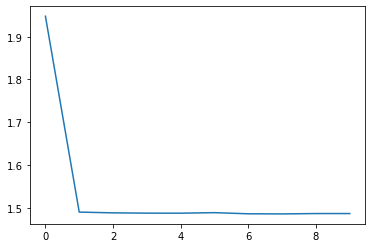

In [ ]:
import matplotlib.pyplot as plt

plt.plot(record, label='loss')